# **Explainable AI with SHAP (SHapley Additive exPlanations)**


- SHAP is a game theoretic approach to explain the output of any machine learning model, which makes it model agnostic. It connects optimal credit allocation with local explanations. Using the classic sharply values from game theory and their related extensions, the goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction.
- This tutorial is designed to help build a basic understanding of how to compute and interpet Shapley-based explanations on deep learning model using the SHAP Python package.

# Pipeline of explainable tool SHAP

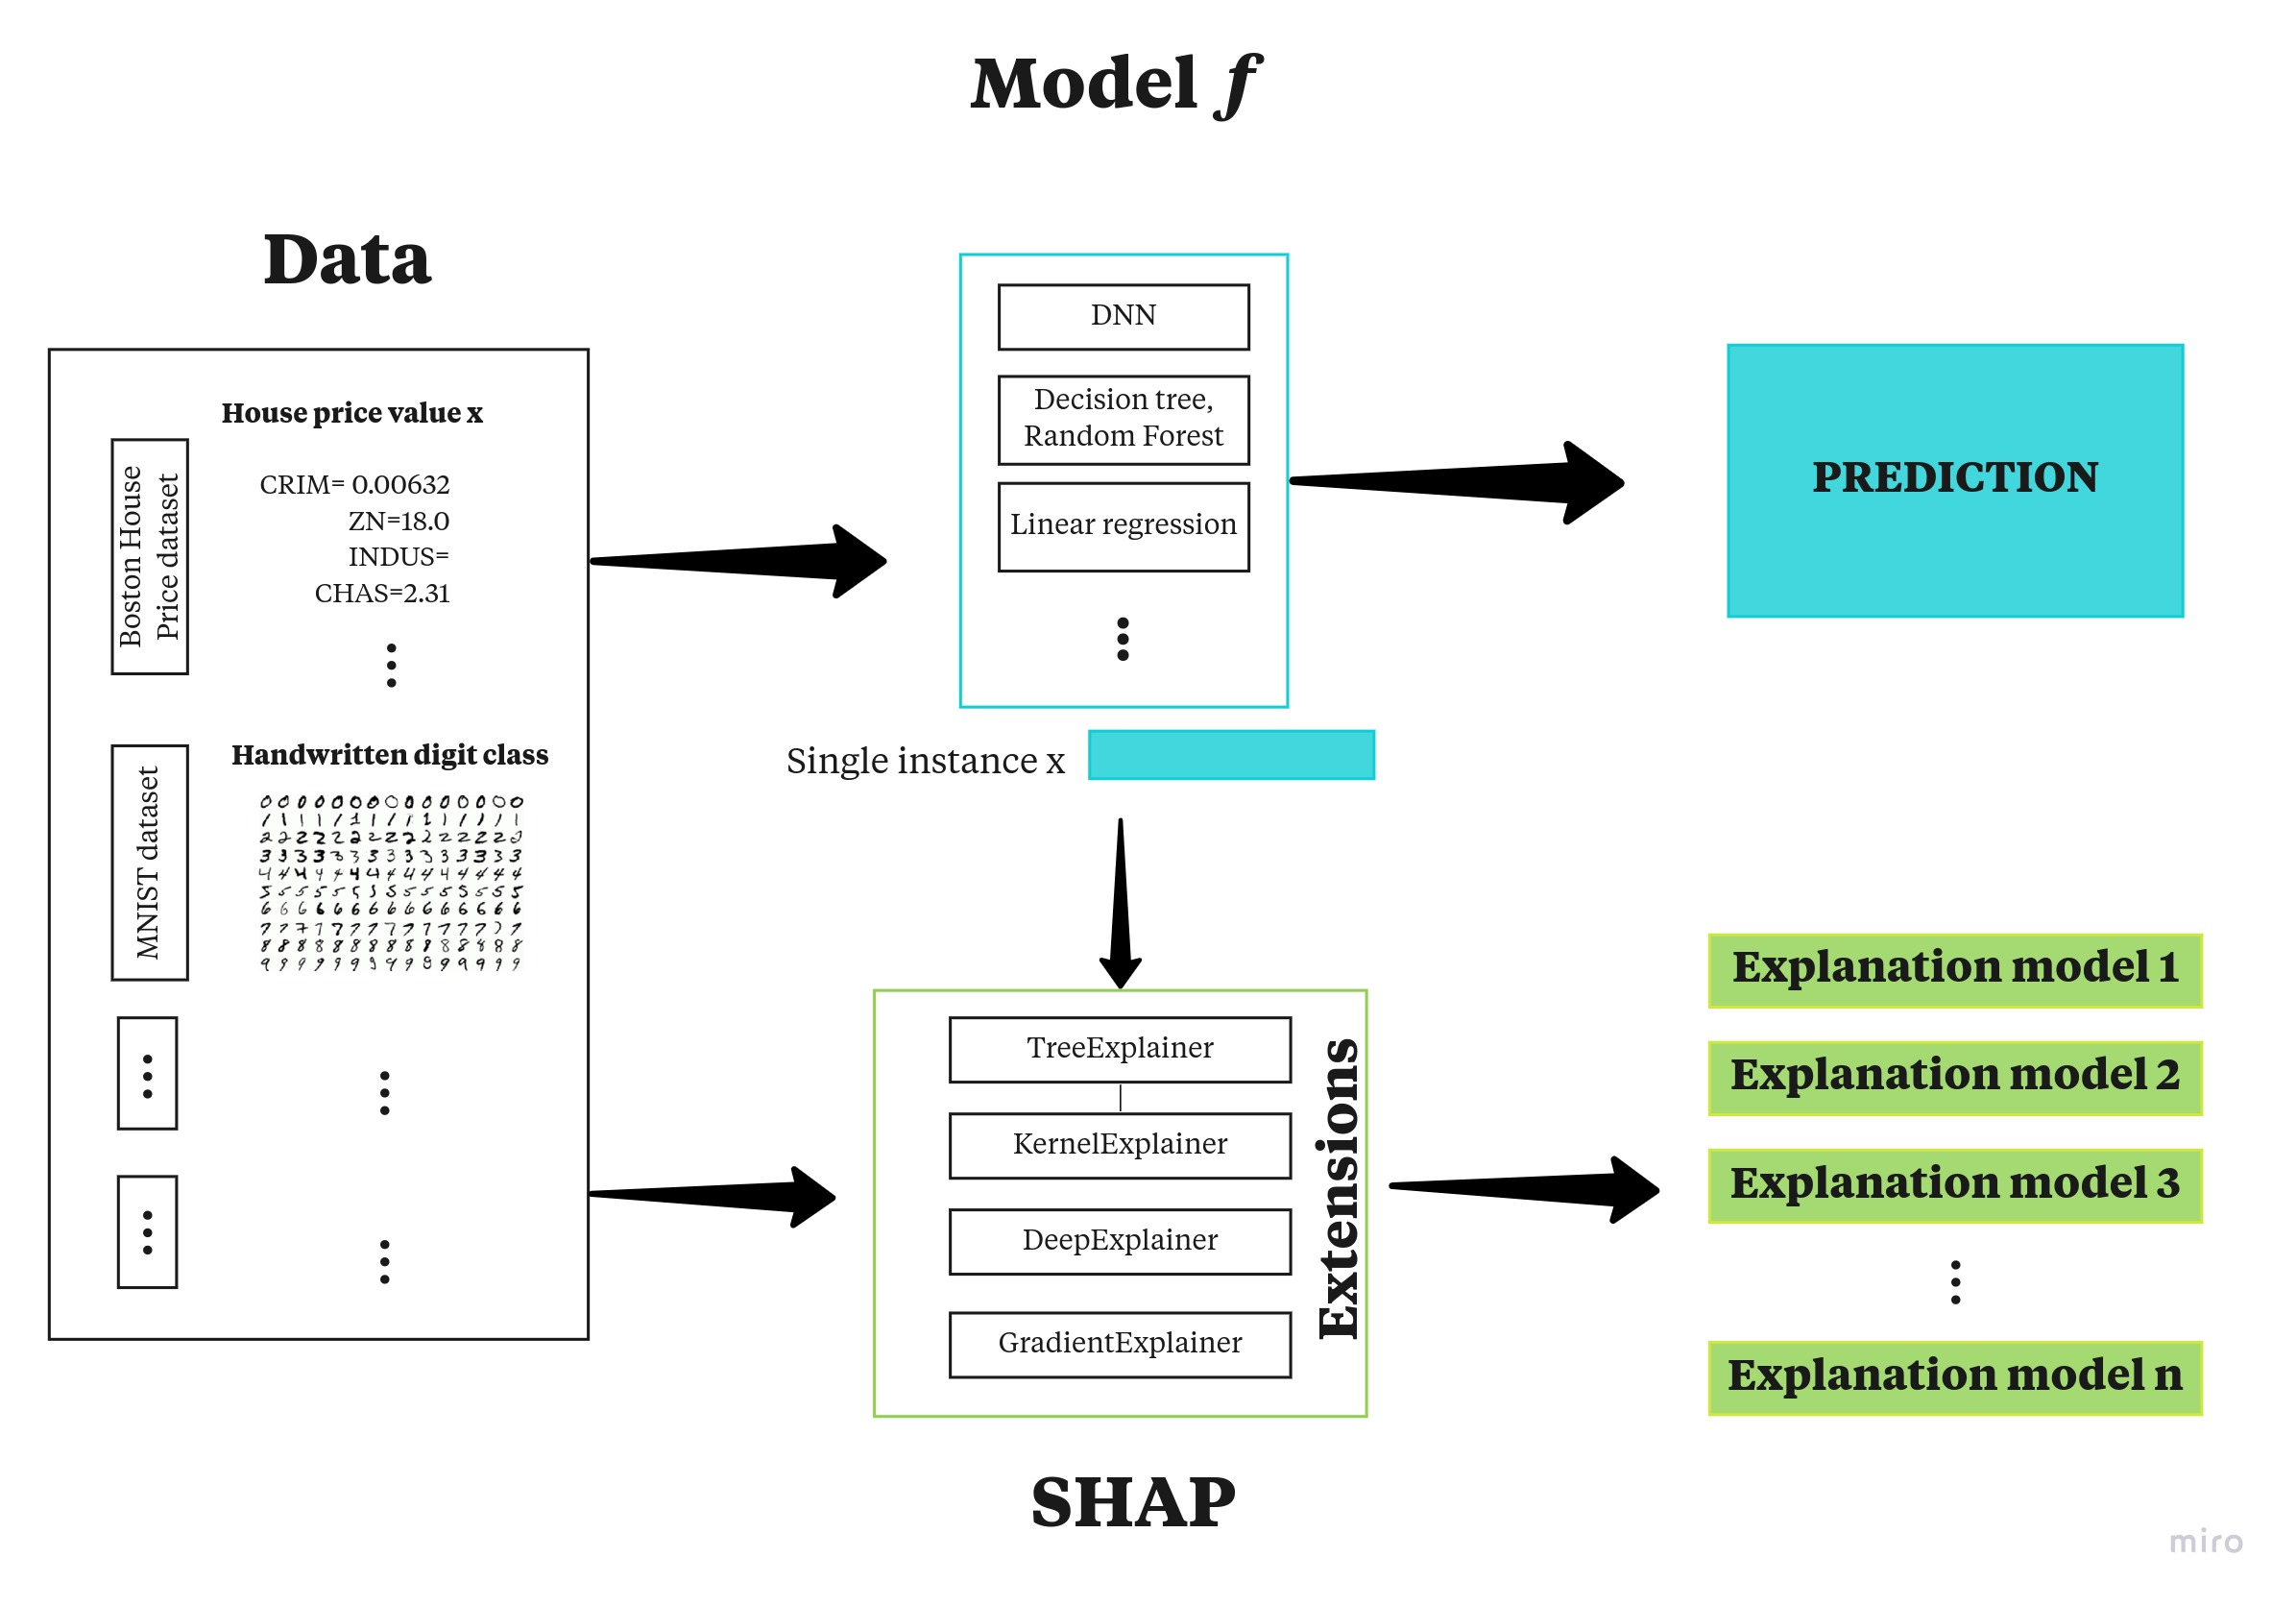

In the model agnostic explainer, SHAP leverages Shapley values in the below manner. To get the importance of feature X{i}:

*  Get all subsets of features S that do not contain X{i}
*  Compute effect on our predictions of adding X{i} to all those subsets
*  Aggregate all contributions to compute the marginal contribution of the feature

Now, for these subsets, SHAP does not go on and retrain the model for each subset. Instead, for the removed or left out feature, it just replaces it with the average value of the feature and generates the predictions.

SHAP EXTENSIONS: 

*   TreeExplainer - high speed exact algorithm for tree ensembles
*   DeepExplainer - high speed approximation algorithm for chef values in deep learning models
*   GradientExplainer -combines ideas from Integrated Gradients, Shap and SmoothGrad into a single expected value equation 
*   KernelExplainer- uses specially-weighted local linear regression to estimate Shap values for any model



# Example 1 - Boston House Prices 
## About the Dataset
We will be working on a data set that comes from the real estate industry in Boston (US). This database contains 14 attributes. The target variable refers to the median value of owner-occupied homes in 1000 USD's.

* CRIM: per capita crime rate by town
* ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
* INDUS: proportion of non-retail business acres per town
* CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
* NOX: nitric oxides concentration (parts per 10 million)
* RM: average number of rooms per dwelling
* AGE: proportion of owner-occupied units built prior to 1940
* DIS: weighted distances to five Boston employment centres
* RAD: index of accessibility to radial highways
* TAX: full-value property-tax rate per 10,000 USD
* PTRATIO: pupil-teacher ratio by town
* B: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
* LSTAT: lower status of the population (%)
* MEDV: Median value of owner-occupied homes in 1000 USD's (Target)


In [ ]:
# setup
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential    
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from Model import train 


#Loading Data

In [ ]:
columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX','PTRATIO', 'B', 'LSTAT', 'PRICE']

In [ ]:
data = pd.read_csv("/content/housing.csv", delim_whitespace=True, header=None)
data.columns = columns
data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [ ]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677082,88.9762
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
CHAS,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
AGE,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


# Data Preparation

In [ ]:
# Here we will split data into X and y
X = data.drop('PRICE', axis=1)
y = data['PRICE']

In [ ]:
# Use the function train_test_split( ) to split our data into two sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
print('Train data:', X_train.shape)
print('Test data:', X_test.shape)

Train data: (354, 13)
Test data: (152, 13)


In [ ]:
def plot_model_hist(hist, feat='loss', figsize=(10, 6)):
    plt.figure(figsize=figsize)
    plt.plot(hist.index, hist[f'{feat}'], label='train')
    plt.plot(hist.index, hist[f'val_{feat}'], label='valid')
    plt.xlabel('epoch')
    plt.ylabel(feat)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
model=train(X_train, y_train, 50)

Epoch 1/50
9/9 [==============================] - 1s 25ms/step - loss: 1414.3026 - val_loss: 800.4285
Epoch 2/50
9/9 [==============================] - 0s 5ms/step - loss: 806.0925 - val_loss: 449.0600
Epoch 3/50
9/9 [==============================] - 0s 4ms/step - loss: 490.2510 - val_loss: 305.3448
Epoch 4/50
9/9 [==============================] - 0s 5ms/step - loss: 356.5659 - val_loss: 262.4218
Epoch 5/50
9/9 [==============================] - 0s 5ms/step - loss: 301.6494 - val_loss: 238.3122
Epoch 6/50
9/9 [==============================] - 0s 4ms/step - loss: 260.1368 - val_loss: 201.1471
Epoch 7/50
9/9 [==============================] - 0s 5ms/step - loss: 216.3694 - val_loss: 167.7444
Epoch 8/50
9/9 [==============================] - 0s 5ms/step - loss: 181.7203 - val_loss: 143.6984
Epoch 9/50
9/9 [==============================] - 0s 5ms/step - loss: 149.2099 - val_loss: 121.7579
Epoch 10/50
9/9 [==============================] - 0s 5ms/step - loss: 122.1158 - val_loss: 121.65

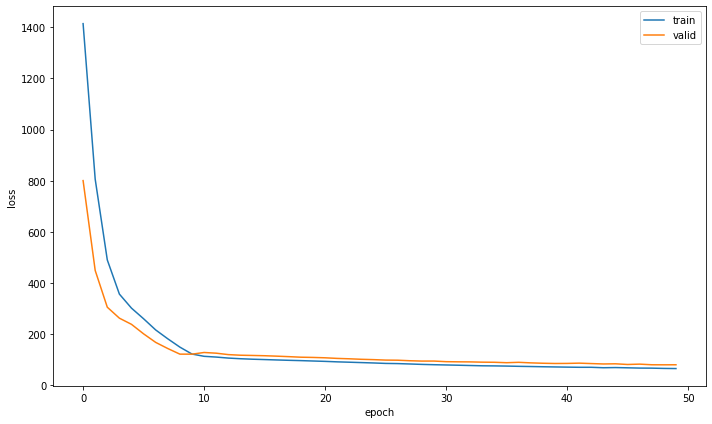

In [ ]:
# Plot Loss as a Function of Number of Epoch
model_hist = pd.DataFrame(model.history.history)
plot_model_hist(model_hist)

In [ ]:
print('MSE (train):', model.evaluate(X_train, y_train),
      '\nMSE (test):', model.evaluate(X_test, y_test))

5/5 [==============================] - 0s 2ms/step - loss: 63.1467
MSE (train): 67.9543685913086 
MSE (test): 63.14665603637695


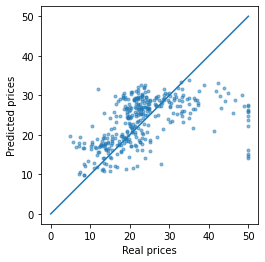

In [ ]:
plt.scatter(y_train, model.predict(X_train), marker='.', alpha=0.5)
plt.plot([0,50],[0,50])
plt.xlabel('Real prices')
plt.ylabel('Predicted prices')
plt.gca().set_aspect('equal')

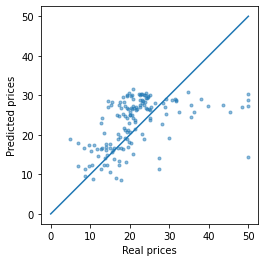

In [ ]:
plt.scatter(y_test, model.predict(X_test), marker='.', alpha=0.5)
plt.plot([0,50],[0,50])
plt.xlabel('Real prices')
plt.ylabel('Predicted prices')
plt.gca().set_aspect('equal')

## Installation

SHAP can be installed from either PyPI or conda-forge:
##### pip install shap
##### or
##### conda install -c conda-forge shap

In [ ]:
!pip install shap

     |████████████████████████████████| 371 kB 6.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509235 sha256=fe1ce35871533caeb57a78e94d58fcfcaa1062e90255e8fa62db299e53923f19
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


In [ ]:
import shap
shap.initjs()

We have trained machine learning model to predict house prices. For a certain house it will predict its  monetary value and you need to explain this prediction. Therefore, we are interested how much has each feature value contributed to the prediction compared to the average prediction.
Although, if model is a deep learning model, it is advisable to use DeepExplainer, in this example, we will showcase SHAP method applicable to any model- KernelExplainer

*   The Kernel Explainer builds a weighted linear regression by using your data, your predictions, and the function that predicts the predicted values
*   It computes the variable importance values based on the Shapley values from game theory, and the coefficients from a local linear regression




In [ ]:
# Fix seed for reproducibility
np.random.seed(123)

# Summarize the training set to accelerate analysis
df_train_normed_summary = shap.kmeans(X_train.values, 25)

# Instantiate an explainer with the model predictions and training data summary
explainer = shap.KernelExplainer(model.predict, df_train_normed_summary)

# Extract Shapley values from the explainer
shap_values = explainer.shap_values(X_train.values)

  0%|          | 0/354 [00:00<?, ?it/s]

## **SHAP Summary Plot**


*   To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. 
*   The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output.
*   The color represents the feature value (red high, blue low). 






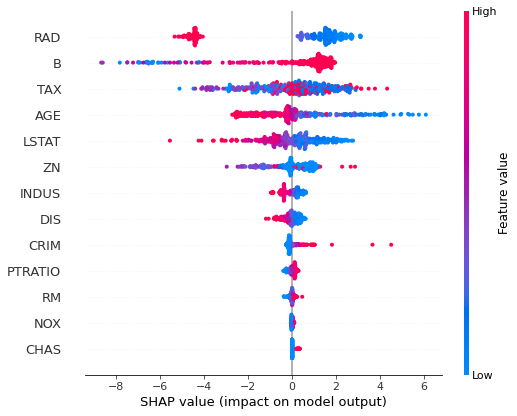

In [ ]:
# Summarize the Shapley values in a plot
shap.summary_plot(shap_values[0], X_train)

*   A summary plot combines feature importance with feature effects. Each point on the summary plot is a shapely value for a feature and an instance.  
*    Feature importance: Variables are ranked in descending order.
*    Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
*    Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.
*    Correlation: A high values of the RAD has a high and negative impact on the house price value. The “high” comes from the red color, and the "negative" impact is shown on the X-axis. Similarly, we will say “B” is positively correlated with the target variable.


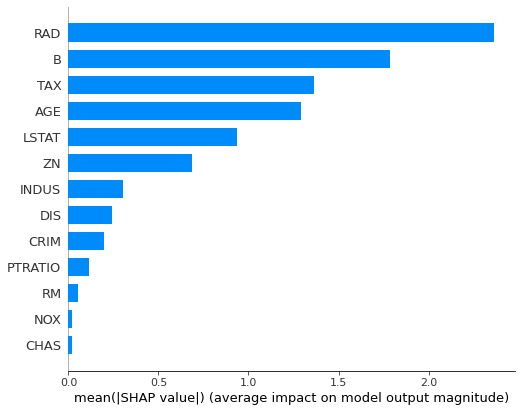

In [ ]:
# We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot 
# Produces stacked bars for multi-class outputs

shap.summary_plot(shap_values[0], X_train,plot_type='bar')

In [ ]:
shap_expl=shap.Explanation(shap_values[0], explainer.expected_value[0],feature_names=X_train.columns)

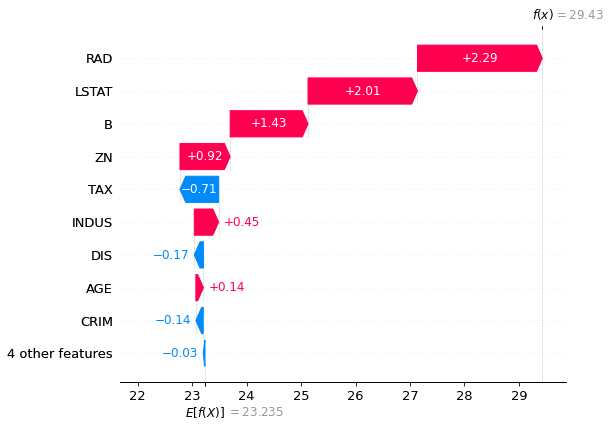

In [ ]:
shap.plots.waterfall(shap_expl[0])

The SHAP waterfall plots aims to explain how individual price predictions are derived.


1.   The Y-axis encodes features and reports the values observed for observation number 0
2.   The X-axis encodes the range of our response (house prices)
1.   The E[f(X)] = 23.235 at the bottom of the chart is the result from the null model, or the global house price from our dataset

1.   The f(x) = 29.43 at the top of the chart is the model prediction for values observed in (1)


## **SHAP Force Plot**

*    The force plots in the SHAP package can output both local and “global” interpretation graphs. While it does not provide a global explanation in the form of an equation like in our GLMs, it does give us a model-level view of the results to work with. This is done by stacking and sorting all the SHAP values for all predictions into 1 plot as shown below.

*   While both axes can be customized from the combo box, by default, the Y-axis shows the output value of the model, while the X-axis plots all the samples in the dataset sorted by similarity (sorting it by output value is easier to read). Hovering over an area of the graph, provides a quick summary of the significant rating factors that are driving the modelled costs up (in red) or down (in blue).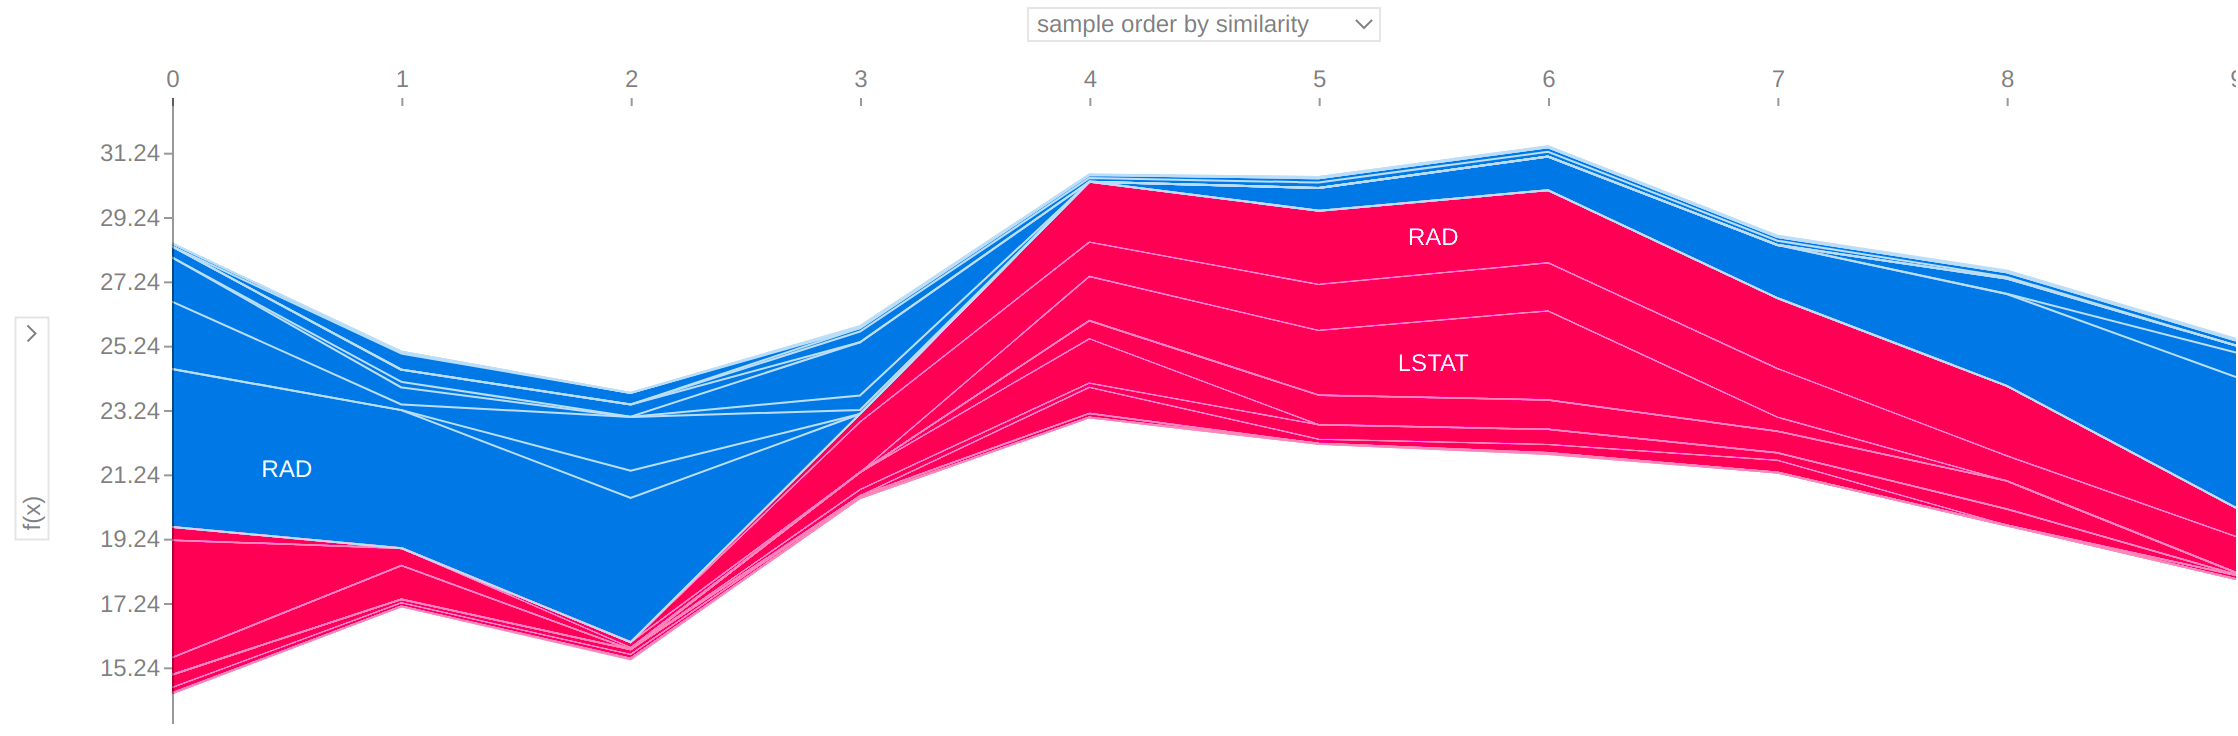

In [ ]:
# Plot the SHAP values for multiple instances
shap.initjs() 
NUM_ROWS = 10
shap.force_plot(explainer.expected_value[0], shap_values[0][0:NUM_ROWS], X_train.iloc[0:NUM_ROWS])

In [ ]:
# Plot the SHAP values for one instance
shap.initjs() 
INSTANCE_NUM = 0
shap.force_plot(explainer.expected_value[0], shap_values[0][INSTANCE_NUM], X_train.iloc[INSTANCE_NUM,:])

*   Each feature value is a force that either increases or decreases the prediction. The prediction starts from the baseline, which for shaply values is the average of all the prediction. Let's explain it in detail:
*  *The output value* is the prediction for that observation (the prediction for this observation is **29.43**).
*   *The base value*: The original paper explains that the base value E(y_hat) is “the value that would be predicted if we did not know any features for the current output.” In other words, it is the mean prediction, or mean(yhat). You may wonder why it is **23.24**. This is because the mean prediction of Y_test is 23.24. 
*   *Red/blue*: In a force plot, each shapely value is displayed as an arrow that pushes the prediction to increase positive values shown here in red or decrease negative values shown here in blue. 


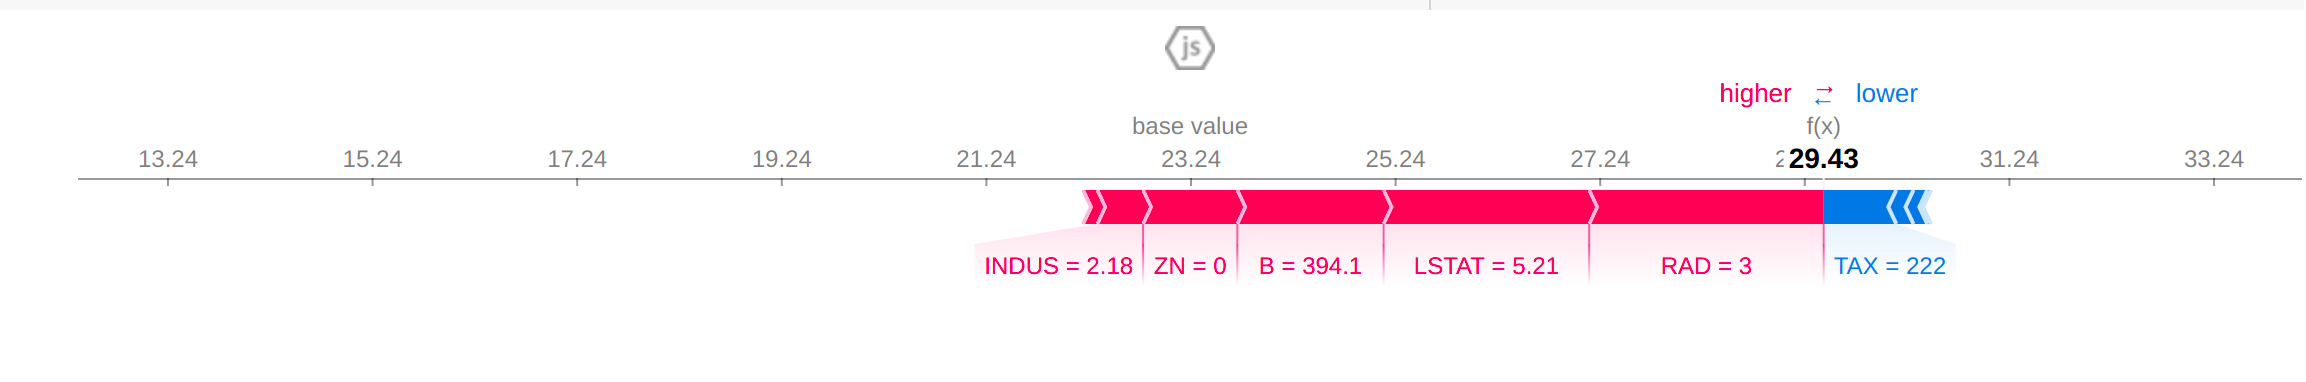

## **SHAP Dependence Plot**


A dependence plot is a scatter plot that shows the effect a single feature has on the predictions made by the model.If an interaction effect is present between this other feature and the feature we are plotting it will show up as a distinct vertical pattern of coloring.
*  Each dot is a single prediction (row) from the dataset.
*  The x-axis is the value of the feature (from the X matrix)
*  The y-axis is the SHAP value for that feature, which represents how much knowing that feature's value changes the output of the model for that sample's prediction.

  

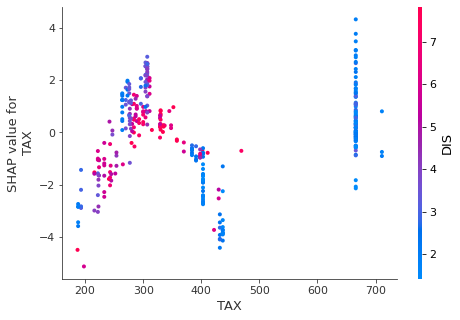

In [ ]:
# Create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('TAX', shap_values[0], X_train, interaction_index='DIS')

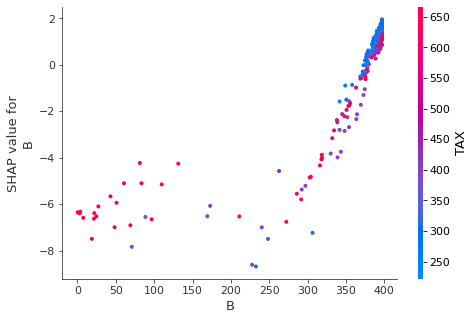

In [ ]:
# Create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('B', shap_values[0], X_train, interaction_index='TAX')

## **SHAP Decision Plot**

*   As like the summary plot, it gives an overall picture of contribution to prediction. From bottom to top of the decision plot, shap values are cumulatively added to the base value of the model in determining the output values.

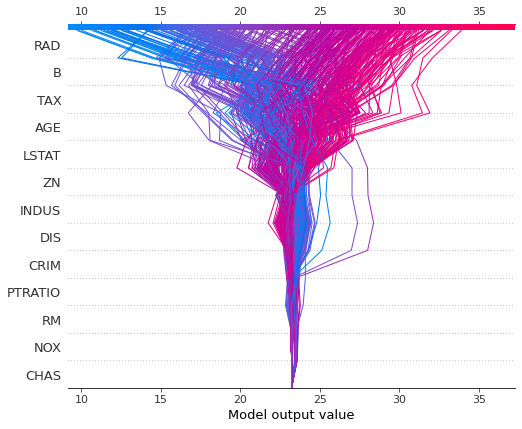

In [ ]:
# decision plot for one instance
#shap_expl=shap.Explanation(shap_values[0], explainer.expected_value[0],feature_names=X_train.columns)
shap.decision_plot(explainer.expected_value[0], shap_values[0], feature_names=list(X_train.columns))  

# Example 2-MNIST Data Set 
## About the Dataset
* The MNIST dataset contains 60,000 training cases and 10,000 test cases of handwritten digits (0 to 9)
* Each digit is normalized and centered in a gray-scale (0 - 255) image with size 28 × 28

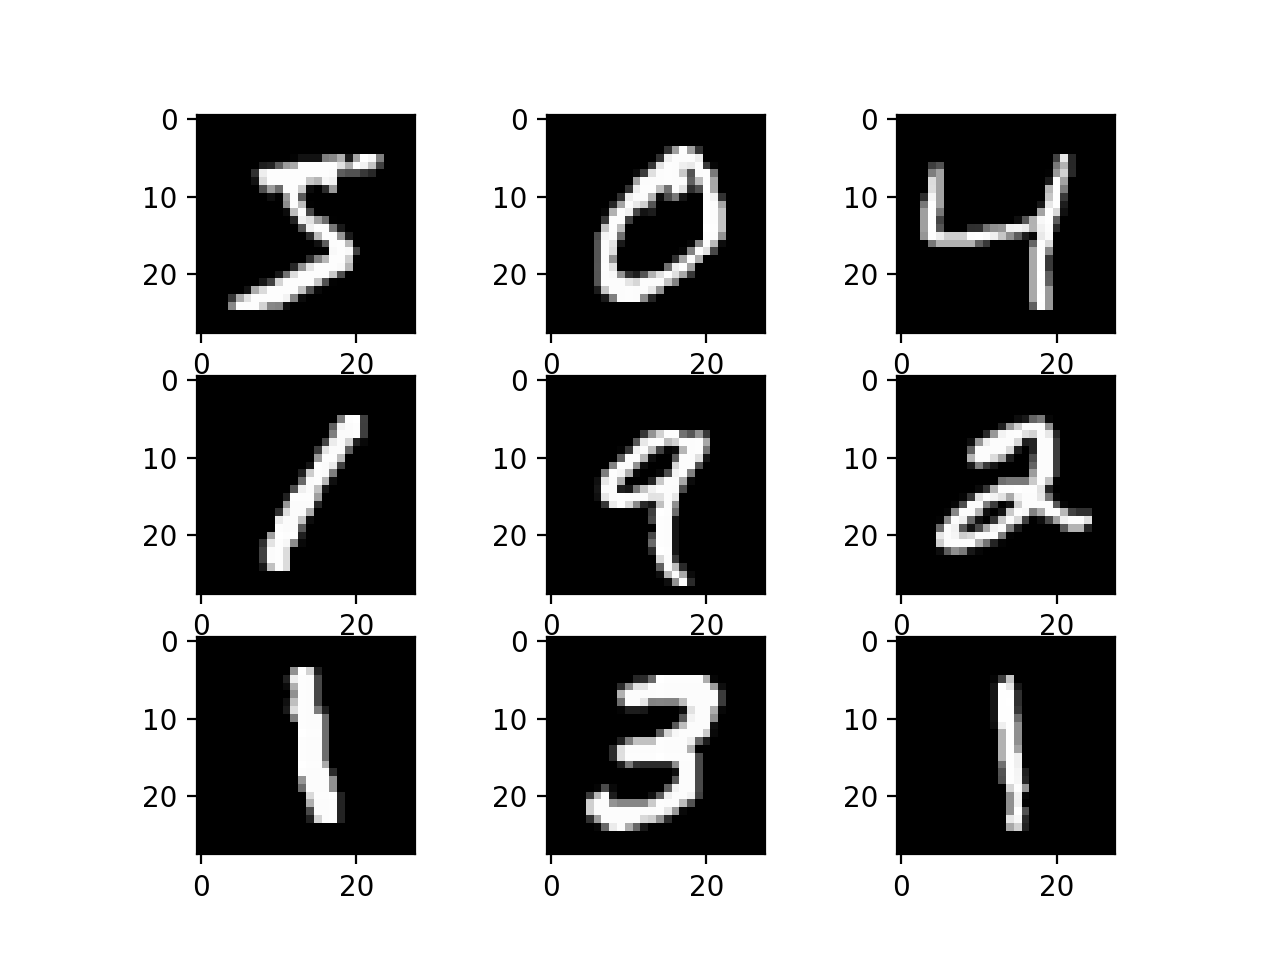

## Importing Libraries

In [ ]:
import keras
from keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [ ]:
batchsize = 512
total_classes = 10
epochs = 10

## Loading Data

In [ ]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()

##Data Preparation

In [ ]:
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

In [ ]:
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

In [ ]:
print(X_train.shape,X_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [ ]:
Y_train = keras.utils.to_categorical(Y_train, total_classes)
Y_test = keras.utils.to_categorical(Y_test, total_classes)

In [ ]:
print(Y_train.shape,Y_test.shape)

(60000, 10) (10000, 10)


##Model Definition

In [ ]:
initial = keras.Input(shape=(28, 28, 1))
X = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(initial)
X = layers.MaxPooling2D(pool_size=(2, 2))(X)
X = layers.Dropout(0.25)(X, training=True)
X = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(X)
X = layers.MaxPooling2D(pool_size=(2, 2))(X)
X = layers.Dropout(0.5)(X, training=True)
X = layers.Flatten()(X)
Final = layers.Dense(total_classes, activation="softmax")(X)
model = keras.Model(inputs=initial, outputs=Final)
model.summary()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                      

## Model Training

In [ ]:
history = model.fit(X_train, Y_train, batch_size = batchsize, epochs= 10, validation_split=0.1, shuffle=True)

In [ ]:
Performance = model.evaluate(X_test, Y_test, verbose=0)
print("Test Accuracy: ", Performance[1])
print("Test Loss: ", Performance[0])

Test Accuracy:  0.9818999767303467
Test Loss:  0.05804413929581642


In [ ]:
#installing shap if not installed
!pip install shap

In [ ]:
import shap
#set data samples for expectation
data = X_train[np.random.choice(X_train.shape[0], 50, replace=False)]

S1 = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), data)
#calculating SHAP Values
ShapValues = S1.shap_values(X_test[1:20], check_additivity=False)

In [ ]:
#Visualizing Feature importance
Plot = shap.image_plot(ShapValues, -X_test[1:10])
display(Plot)

###The plot above demonstrates predictions for 9 images; 2,1,0,4,1,4,9,5,4. 
* The Prediction trend is from left to right
* Red pixels refer to an improvement in output
* Blue pixels refer to a reduction in output

In [ ]:
Plot = shap.image_plot(ShapValues, -X_test[10:20])
display(Plot)

## **Conclusion**

Shapley values provide a uniform approach to decompose a model’s predictions into contributions that can be attributed additively to different explanatory variables. It is a method originally invented for assigning payouts to players depending on their contribution towards the total payout. In the explanation setting, the features are the players and the prediction is the total payout. In this framework, we can reflect advantages on global and local level

*  Global interpretability — the SHAP values can show how much each predictor contributes, either positively or negatively, to the target variable. This is like the variable importance plot but it is able to show the positive or negative relationship for each variable with the target (see the summary plots below).
*    Local interpretability — each observation gets its own set of SHAP values (see the individual force plots below). This greatly increases its transparency. We can explain why a case receives its prediction and the contributions of the predictors. Traditional variable importance algorithms only show the results across the entire population but not on each individual case. The local interpretability enables us to pinpoint and contrast the impacts of the factors.

An important drawback of Shapley values is that they provide additive contributions (attributions) of explanatory variables. If the model is not additive, then the Shapley values may be misleading. This issue can be seen as arising from the fact that, in cooperative games, the goal is to distribute the payoff among payers. However, in the predictive modelling context, we want to understand how do the players affect the payoff? Thus, we are not limited to independent payoff-splits for players.

## **Future Work**

*  Comparison of Interpretability Methods to Explain Deep Learning Models on Boston prices/MNIST/other data
*  Can SHAP be applied to a super learner ensemble method?



## **References**

######  - Github repo: https://github.com/slundberg/shap
######  - A Unified Approach to Interpreting Model Predictions: https://arxiv.org/pdf/1705.07874v2.pdf
##### - https://towardsdatascience.com/a-novel-approach-to-feature-importance-shapley-additive-explanations-d18af30fc21b#5280
######  - Introduction to Shapley values, https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html
######  - https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a
######  - Shapley Additive Explanations (SHAP) for Average Attributions: https://ema.drwhy.ai/shapley.html
######  - https://christophm.github.io/interpretable-ml-book/
######  - Aas, Kjersti et al. “Explaining individual predictions when features are dependent: More accurate approximations to Shapley values.” Artif. Intell. 298 (2021): 103502.
######  - https://towardsdatascience.com/pytorch-shap-explainable-convolutional-neural-networks-ece5f04c374f
######  SHapley Additive exPlanations (SHAP), https://www.coursera.org/lecture/machine-learning-modeling-pipelines-in-production/shapley-additive-explanations-shap-F3NDQ
######  https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a
######  DeepExplainer, https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html
###### https://www.analyticsvidhya.com/blog/2019/11/shapley-value-machine-learning-interpretability-game-theory/
###### KernelExplainer, https://shap-lrjball.readthedocs.io/en/latest/generated/shap.KernelExplainer.html

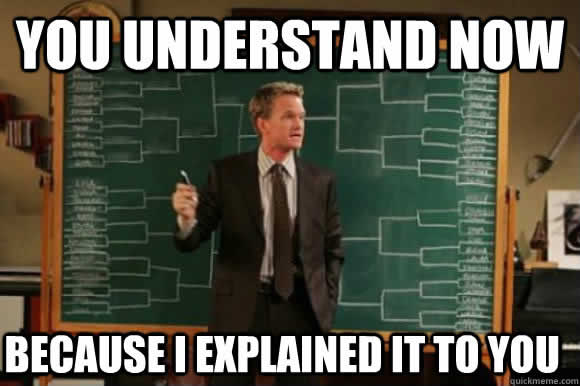